In [17]:
from __future__ import print_function    # (at top of module)
import warnings
warnings.filterwarnings('always')
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
from matplotlib.pyplot import figure
import math
import seaborn as sns
import io, os, sys, types

In [18]:
# Read the data from the file
data = pd.read_csv('Data/data_500_entries_youtube.csv')
print("Number of entries in original data: " + str(len(data.index)))
data.head()

Number of entries in original data: 570


,song_id,song_title,artist,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,youtube_view_count,youtube_video_title
0,spotify:track:5ygDXis42ncn6kYG14lEVG,Baby Shark,[Pinkfong],77,0.840,0.3410,115.062,0.2270,0.2450,0.000000,4,0.825,7,96333,-3.651,0.520,1,1956582159,Baby Shark Dance | Sing and Dance! | Animal So...
1,spotify:track:7fa9MBXhVfQ8P8Df9OEbD8,Girls Like You (feat. Cardi B),"[Maroon 5, Cardi B]",86,0.541,0.1300,124.959,0.0505,0.5680,0.000000,4,0.851,0,235545,-6.825,0.448,1,1300452389,Maroon 5 - Girls Like You ft. Cardi B
2,spotify:track:6De0lHrwBfPfrhorm9q1Xl,Me Rehúso,[Danny Ocean],83,0.804,0.0494,104.823,0.0677,0.0231,0.000000,4,0.744,1,205715,-6.327,0.426,1,1229501096,Danny Ocean - Me Rehúso (Official Audio)
3,spotify:track:1j6xOGusnyXq3l6IryKF3G,Déjala Que Vuelva (feat. Manuel Turizo),"[Piso 21, Manuel Turizo]",74,0.788,0.0753,170.019,0.0785,0.0482,0.000000,4,0.681,1,220117,-4.323,0.839,1,1216075058,Piso 21 - Déjala Que Vuelva (feat. Manuel Turi...
4,spotify:track:2ijef6ni2amuunRoKTlgww,Sin Pijama,"[Becky G, Natti Natasha]",90,0.745,0.1040,94.014,0.0464,0.3540,0.000029,4,0.791,11,188560,-3.695,0.820,0,1071141995,Becky G Natti Natasha - Sin Pijama (Video Ofic...


In [19]:
if 'song_id' in data.columns:
    data = data.drop_duplicates(subset=['song_id'], keep='first')
else:
    data = data.drop_duplicates(subset=['song_title'], keep='first')
    
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 570


In [20]:
#data = data[data.total_no_streams > 10000000]
#print("Number of entries in original data after cleaning: " + str(len(data.index)))

In [21]:
from project_modules import *

#final_data = label_data_combined(data, 90, 1000000000)
final_data = label_data(data, 89)

Number of popular examples after thresholding :  55
Number of not popular examples after thresholding :  515


In [22]:
# Drop unnecessary columns from original data - also some legacy support for a different data format
if 'song_id' in data.columns:
    final_data.drop(['song_id', 'song_title', 'artist', 'popularity', 'youtube_view_count', 'youtube_video_title'], 1, inplace=True)
else:
    final_data.drop(['song_title', 'artist', 'popularity'], 1, inplace=True) 

In [23]:
# X will be our examples and y will be our labels
X = final_data.drop('is_popular', axis=1)
y = final_data['is_popular']
# Sanity checks
print("Number of entries in actual data: " + str(len(X.index)))
print("Number of entries in label data: " + str(len(y.index)))

Number of entries in actual data: 570
Number of entries in label data: 570


In [24]:
# We split the data into training and testing data
from sklearn.model_selection import train_test_split
X_fs, X_test, y_fs, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
#print("Items in training data set : ", str(len(X_train.index)))
#print("Items in testing data set: ", str(len(X_test.index)))

In [25]:
COLUMNS_TO_SCALE = ["energy", "liveness", "tempo", 
                    "speechiness", "acousticness", "instrumentalness", 
                    "time_signature", "danceability", "key", 
                    "duration", "loudness", "valence", "mode"]
#COLUMNS_TO_SCALE = ["energy", "tempo","loudness", "valence"]

# Keep data in a temp variable for testing
#scaled_data = scale_data_standardize(final_data, COLUMNS_TO_SCALE)

# Plots to see the difference before/after scaling
# plt.subplot(1,2,1)
# plt.plot(data['duration'])
# plt.title("Duration before scaling")

# plt.subplot(1,2,2)
# plt.plot(scaled_data['duration'])
# plt.title("Duration after scaling")
# plt.tight_layout()
# plt.show()

# Copy data back
#final_data = scaled_data.copy()

#Just to check that everything is fine
#final_data.head()

In [26]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X_fs)
# Plots to see the difference before/after scaling
# plt.subplot(1,2,1)
# plt.plot(data['duration'])
# plt.title("Duration before scaling")

# plt.subplot(1,2,2)
# plt.plot(scaled_data['duration'])
# plt.title("Duration after scaling")
# plt.tight_layout()
# plt.show()

# Copy data back
X_fs = pd.DataFrame(scaler.transform(X_fs), columns=COLUMNS_TO_SCALE)
X_test = pd.DataFrame(scaler.transform(X_test), columns=COLUMNS_TO_SCALE)

#Just to check that everything is fine

C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Rares\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
C:\Users\Rares\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [27]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# models = [
#           {'title':"Gaussian Naive Bayes", 'model':GaussianNB(), 'feature_set':'all'},
#           {'title':"Logistic regression", 'model':LogisticRegression(solver='lbfgs', random_state=3), 'feature_set':'all'},
#           {'title':"Logistic regression balanced weights", 'model':LogisticRegression(solver='lbfgs',class_weight='balanced', random_state=3), 'feature_set':['energy', 'tempo', 'instrumentalness', 'danceability', 'loudness', 'valence']},
#           {'title':"Oversampling logistic regression", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(solver='lbfgs',random_state=3)), 'feature_set':['energy', 'danceability', 'loudness', 'valence']},
#           {'title':"Oversampling logistic regression balanced weights", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(solver='lbfgs',class_weight='balanced',random_state=3)), 'feature_set':'all'},
#           {'title':"KNN", 'model':KNeighborsClassifier(n_neighbors = 1), 'feature_set':'all'},
#           {'title':"Oversampling KNN", 'model':make_pipeline_imb(SMOTE(random_state=4), KNeighborsClassifier(n_neighbors = 1)), 'feature_set':['energy', 'liveness', 'acousticness', 'instrumentalness', 'danceability', 'loudness', 'valence']},
#           {'title':"SVM", 'model':svm.SVC(probability=True, gamma='scale', random_state=3), 'feature_set':'all'},
#           {'title':"SVM balanced weights", 'model':svm.SVC(probability=True, gamma='scale', random_state=3, class_weight='balanced'), 'feature_set':'all'},#['energy', 'tempo', 'acousticness', 'danceability', 'loudness', 'valence']},
#           {'title':"Oversampling SVM", 'model':make_pipeline_imb(SMOTE(random_state=4), svm.SVC(probability=True, gamma='scale', random_state=3)), 'feature_set':['energy', 'tempo', 'speechiness', 'loudness', 'valence']},
#           {'title':"Multilayer Perceptron", 'model':MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=3), 'feature_set':['energy', 'tempo', 'key', 'duration', 'loudness', 'valence']},
#           {'title':"Oversampling Multilayer Perceptron", 'model':make_pipeline_imb(SMOTE(random_state=4), MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=3)), 'feature_set':['energy', 'tempo', 'time_signature', 'duration', 'loudness', 'valence']},
#           {'title':"Random Forest Classifier balanced weights", 'model':RandomForestClassifier(n_estimators=100, max_depth=2, random_state=3, class_weight="balanced"), 'feature_set':['liveness', 'acousticness', 'instrumentalness', 'time_signature', 'danceability', 'duration', 'valence', 'mode']},
#           {'title':"AdaBoost", 'model':AdaBoostClassifier(n_estimators=100), 'feature_set':'all'}
#          ]
models = [
          {'title':"Gaussian Naive Bayes", 'model':GaussianNB(), 'feature_set':'all'},
          {'title':"Logistic regression", 'model':LogisticRegression(solver='lbfgs', random_state=3), 'feature_set':'all'},
          {'title':"Logistic regression balanced weights", 'model':LogisticRegression(solver='lbfgs',class_weight='balanced', random_state=3), 'feature_set':'all'},
          {'title':"Oversampling logistic regression", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(solver='lbfgs',random_state=3)), 'feature_set':'all'},
          {'title':"Oversampling logistic regression balanced weights", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(solver='lbfgs',class_weight='balanced',random_state=3)), 'feature_set':'all'},
          {'title':"KNN", 'model':KNeighborsClassifier(n_neighbors = 17), 'feature_set':'all'},
          {'title':"Oversampling KNN", 'model':make_pipeline_imb(SMOTE(random_state=4), KNeighborsClassifier(n_neighbors = 17)), 'feature_set':'all'},
          {'title':"SVM", 'model':svm.SVC(probability=True, gamma='scale', random_state=3), 'feature_set':'all'},
          {'title':"SVM balanced weights", 'model':svm.SVC(probability=True, gamma='scale', random_state=3, class_weight='balanced'), 'feature_set':'all'},
          {'title':"Oversampling SVM", 'model':make_pipeline_imb(SMOTE(random_state=4), svm.SVC(probability=True, gamma='scale', random_state=3)), 'feature_set':'all'},
          {'title':"Multilayer Perceptron", 'model':MLPClassifier(activation = 'relu', solver='lbfgs', alpha=1, hidden_layer_sizes=(5, 2), random_state=3), 'feature_set':'all'},
          {'title':"Oversampling Multilayer Perceptron", 'model':make_pipeline_imb(SMOTE(random_state=4), MLPClassifier(activation = 'relu', solver='lbfgs', alpha=1, hidden_layer_sizes=(5, 2), random_state=3)), 'feature_set':'all'},
          {'title':"Random Forest Classifier balanced weights", 'model':RandomForestClassifier(n_estimators=100, max_depth=13, random_state=3, class_weight="balanced"), 'feature_set':'all'},
          {'title':"AdaBoost", 'model':AdaBoostClassifier(n_estimators=100), 'feature_set':'all'}
         ]
stats_columns = ["Model title", "Accuracy", "Specificity", "Recall(Sensitivity)", "Precision", "F1", "AUC"]

Gaussian Naive Bayes


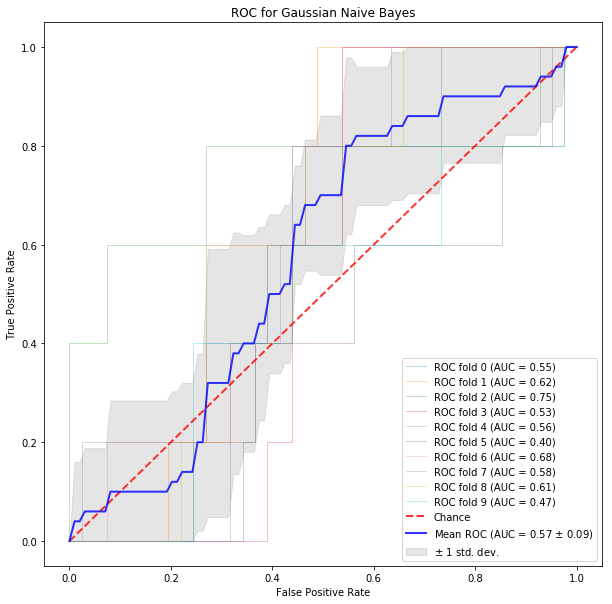

Accuracy mean:  0.3652173913043478

Logistic regression


C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classificatio

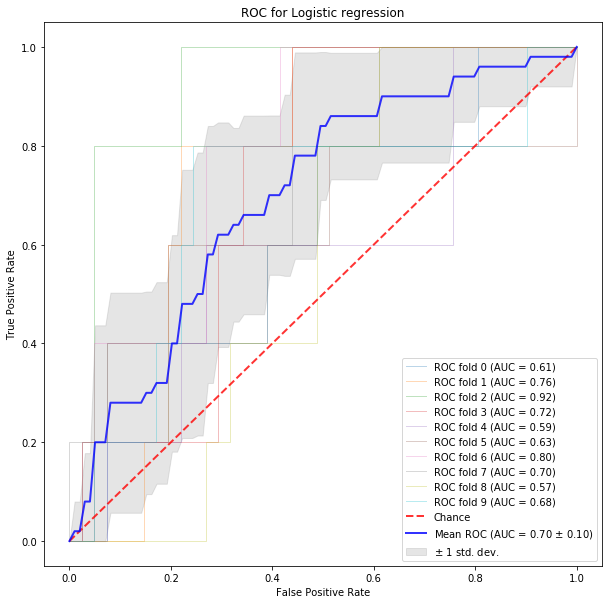

Accuracy mean:  0.8891304347826086

Logistic regression balanced weights


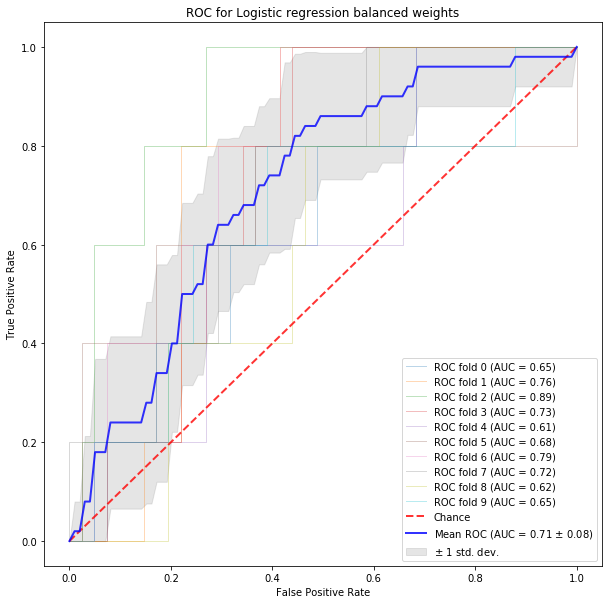

Accuracy mean:  0.6108695652173913

Oversampling logistic regression


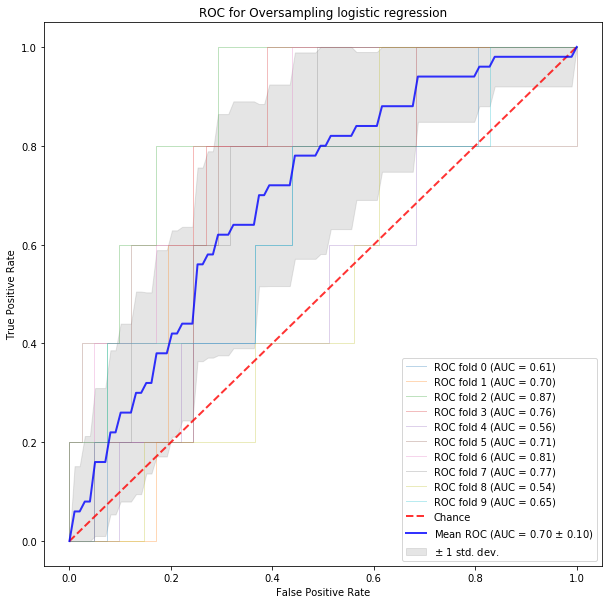

Accuracy mean:  0.6217391304347827

Oversampling logistic regression balanced weights


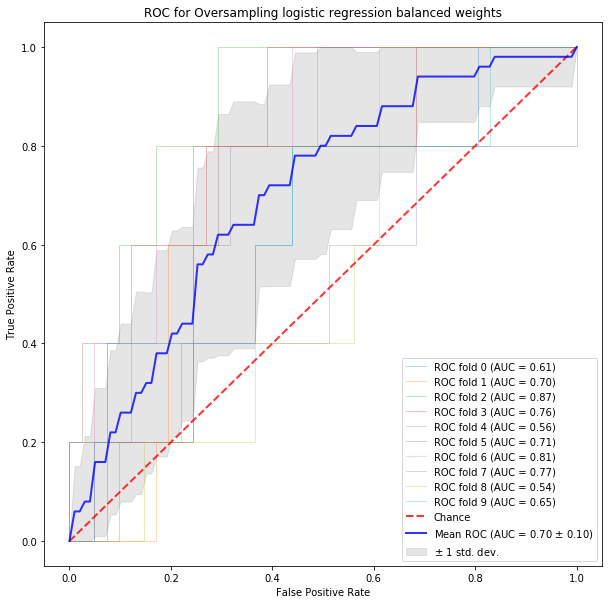

Accuracy mean:  0.6217391304347827

KNN


C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classificatio

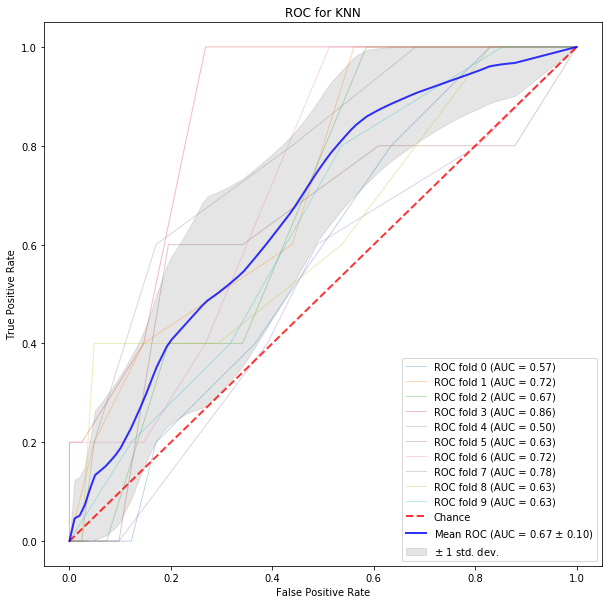

Accuracy mean:  0.8913043478260867

Oversampling KNN


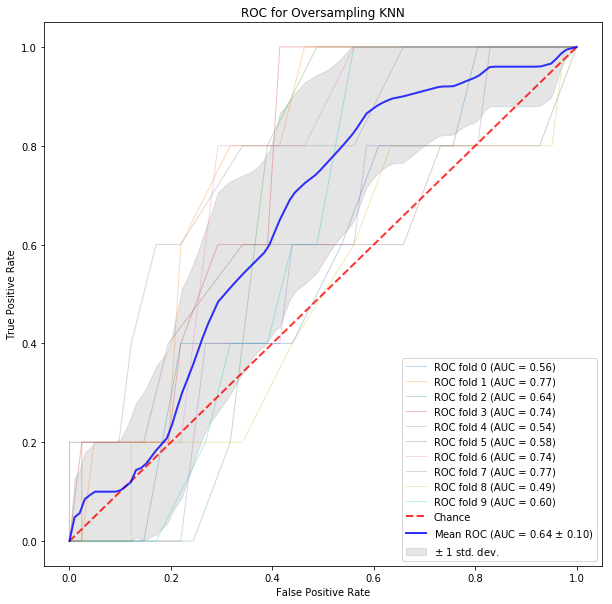

Accuracy mean:  0.5434782608695652

SVM


C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classificatio

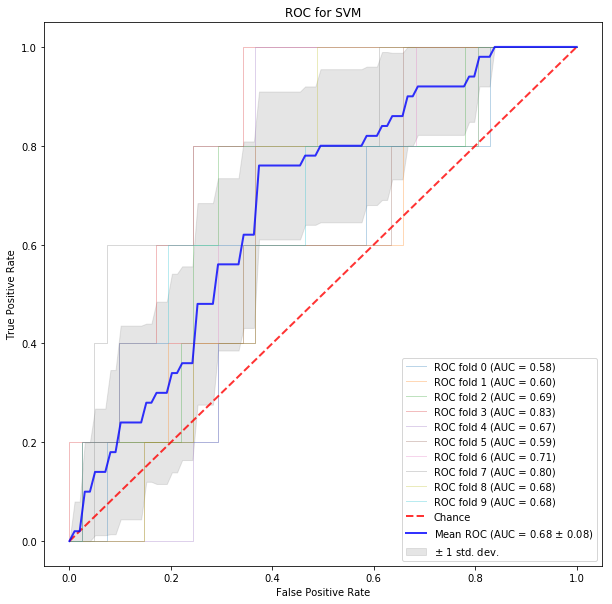

Accuracy mean:  0.8913043478260867

SVM balanced weights


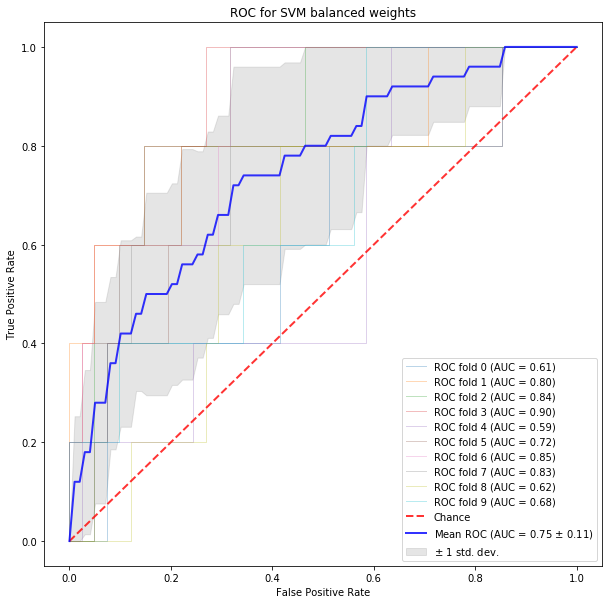

Accuracy mean:  0.717391304347826

Oversampling SVM


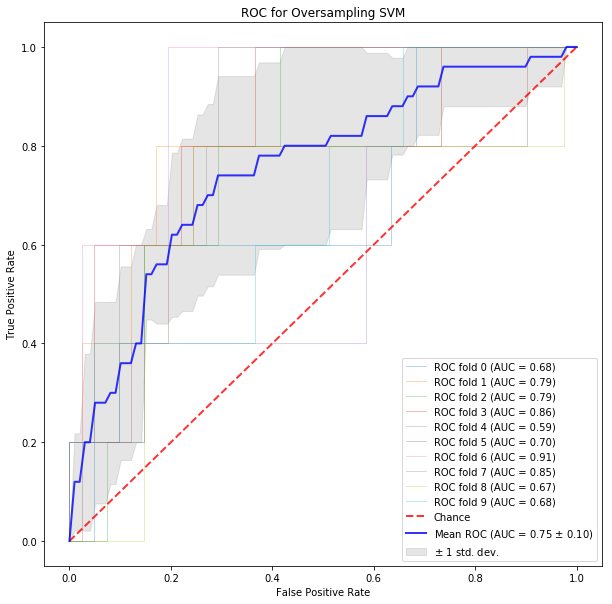

Accuracy mean:  0.7739130434782608

Multilayer Perceptron


C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classificatio

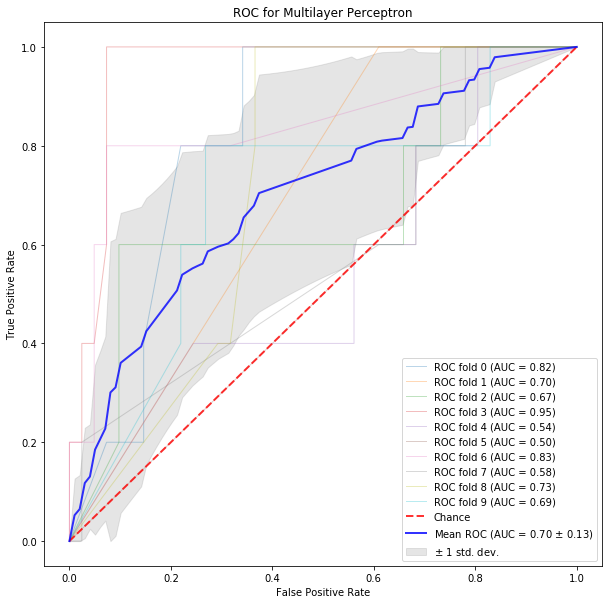

Accuracy mean:  0.8891304347826086

Oversampling Multilayer Perceptron


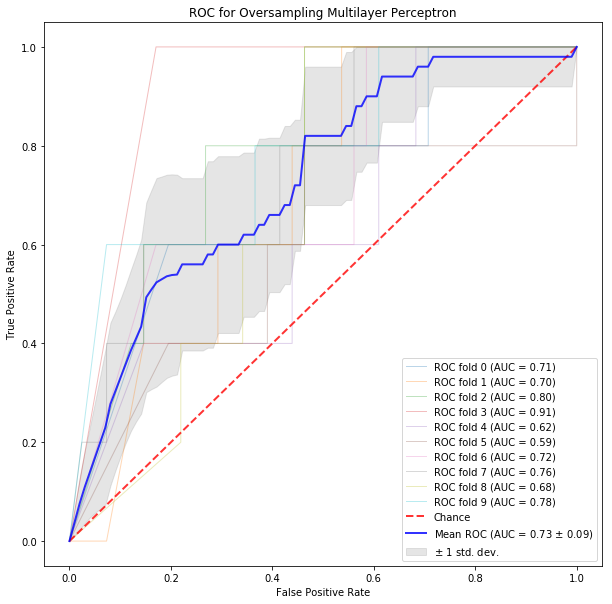

Accuracy mean:  0.7652173913043477

Random Forest Classifier balanced weights


C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classificatio

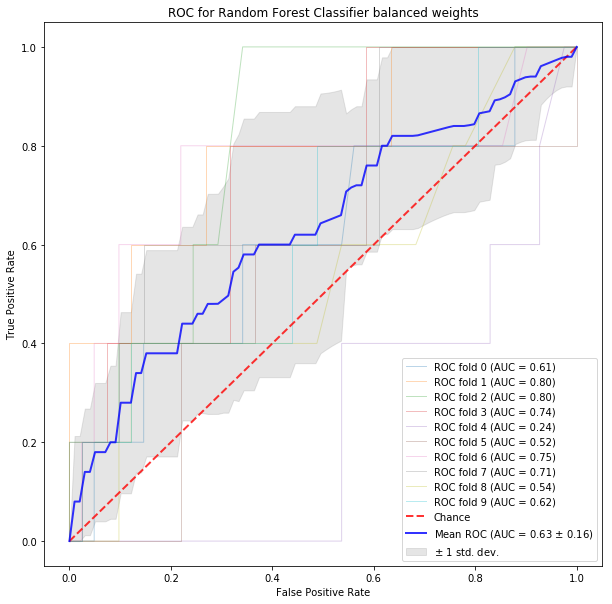

Accuracy mean:  0.8934782608695653

AdaBoost


C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Rares\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


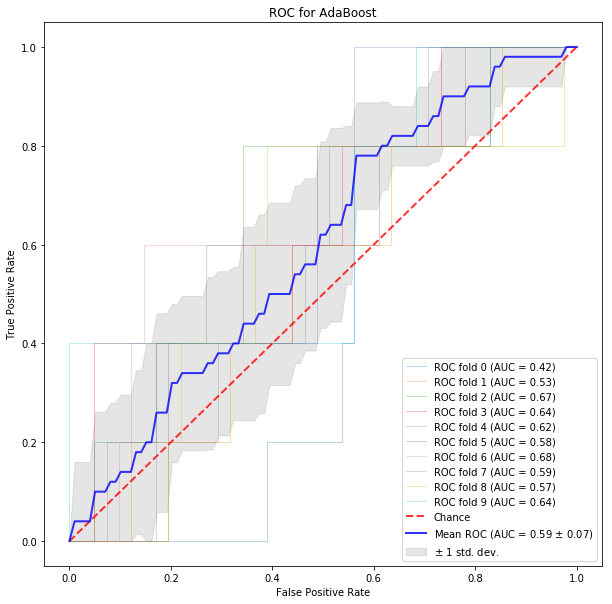

Accuracy mean:  0.8260869565217392



,Model title,Accuracy,Specificity,Recall(Sensitivity),Precision,F1,AUC,Generalized AUC
0,Gaussian Naive Bayes,0.365217,0.307317,0.84,0.129831,0.432877,0.573737,0.449933
1,Logistic regression,0.889130,0.997561,0.00,0.000000,0.838984,0.697980,0.495327
2,Logistic regression balanced weights,0.610870,0.595122,0.74,0.183154,0.680524,0.711313,0.485981
3,Oversampling logistic regression,0.621739,0.617073,0.66,0.174008,0.691069,0.698586,0.514019
4,Oversampling logistic regression balanced weights,0.621739,0.617073,0.66,0.174008,0.691069,0.698586,0.514019
5,KNN,0.891304,1.000000,0.00,0.000000,0.840080,0.671028,0.732977
6,Oversampling KNN,0.543478,0.519512,0.74,0.159754,0.624358,0.643132,0.688919
7,SVM,0.891304,1.000000,0.00,0.000000,0.840080,0.681212,0.666222
8,SVM balanced weights,0.717391,0.731707,0.60,0.216056,0.765044,0.746061,0.659546
9,Oversampling SVM,0.773913,0.809756,0.48,0.229841,0.802569,0.751717,0.708945


In [28]:
from sklearn import svm, datasets
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
stats_columns = ["Model title", "Accuracy", "Specificity", "Recall(Sensitivity)", "Precision", "F1", "AUC", "Generalized AUC"]
#X = np.array(X)
#y = np.array(y)
cv = StratifiedShuffleSplit(n_splits=10, random_state=5)
cv_stats = []

#print(X_fs.head())

for item in models:
    # Run classifier with cross-validation and plot ROC curves
    print(item['title'])
    classifier = item['model']
    tprs = []
    aucs = []
    accs = []
    specificities = []
    recalls = []
    precisions = []
    f1s = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    cur_feature_set=item['feature_set']
    if(cur_feature_set == 'all'):
        X_cfs=np.array(X_fs)
        cur_feature_set= COLUMNS_TO_SCALE
    else:
        X_cfs=np.array(X_fs[cur_feature_set])
    y_fs = np.array(y_fs)
#     print(X_cfs.head())
    for train, test in cv.split(X_cfs, y_fs):
        probas_ = classifier.fit(X_cfs[train], y_fs[train]).predict_proba(X_cfs[test])
        predicts = classifier.predict(X_cfs[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_fs[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        conf_matrix = confusion_matrix(y_fs[test], predicts)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        accs.append(accuracy_score(y_fs[test], predicts))
        specificities.append(float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1]))
        recalls.append(recall_score(y_fs[test], predicts))
        precisions.append(precision_score(y_fs[test], predicts))
        f1s.append(f1_score(y_fs[test], predicts, average='weighted'))
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + item['title'])
    plt.legend(loc="lower right")
    plt.show()

    print("Accuracy mean: ",np.mean(accs))
    print()
    item['model'].fit(X_cfs, y_fs)
    y_pred_prob = item['model'].predict_proba(X_test[cur_feature_set])[:,1]
    test_after_auc = roc_auc_score(y_test, y_pred_prob)
    newRow = [item['title'],np.mean(accs), np.mean(specificities), np.mean(recalls), np.mean(precisions), np.mean(f1s), mean_auc, test_after_auc]
    cv_stats.append(newRow)
stats_df = pd.DataFrame(cv_stats, columns = stats_columns)
stats_df

# Gridsearch 

In [ ]:
# this code is from http://www.davidsbatista.net/blog/2018/02/23/model_optimization/
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=10, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [ ]:
# models = [
#           {'title':"Logistic regression", 'model':LogisticRegression(random_state=3), 'feature_set':['liveness', 'tempo', 'acousticness', 'danceability', 'key', 'duration']},
#           {'title':"Logistic regression balanced weights", 'model':LogisticRegression(class_weight='balanced', random_state=3), 'feature_set':['tempo', 'acousticness', 'danceability', 'valence']},
#           {'title':"Oversampling logistic regression", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(random_state=3)), 'feature_set':['tempo', 'acousticness', 'danceability', 'key', 'valence']},
#           {'title':"Oversampling logistic regression balanced weights", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(class_weight='balanced',random_state=3)), 'feature_set':['tempo', 'acousticness', 'danceability', 'key', 'valence']},
#           {'title':"KNN", 'model':KNeighborsClassifier(n_neighbors = 17), 'feature_set':['liveness', 'tempo', 'acousticness', 'danceability']},
#           {'title':"Oversampling KNN", 'model':make_pipeline_imb(SMOTE(random_state=4), KNeighborsClassifier(n_neighbors = 17)), 'feature_set':['energy', 'instrumentalness', 'duration', 'valence', 'mode']},
#           {'title':"SVM", 'model':svm.SVC(probability=True, gamma='scale', random_state=3), 'feature_set':['liveness', 'tempo', 'acousticness', 'danceability', 'loudness', 'mode']},
#           {'title':"SVM balanced weights", 'model':svm.SVC(probability=True, gamma='scale', random_state=3, class_weight='balanced'), 'feature_set':['speechiness', 'key']},
#           {'title':"Oversampling SVM", 'model':make_pipeline_imb(SMOTE(random_state=4), svm.SVC(probability=True, gamma='scale', random_state=3)), 'feature_set':['tempo', 'time_signature']},
#           {'title':"Multilayer Perceptron", 'model':MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=3), 'feature_set':['energy', 'acousticness', 'danceability', 'duration', 'valence', 'mode']},
#           {'title':"Oversampling Multilayer Perceptron", 'model':make_pipeline_imb(SMOTE(random_state=4), MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=3)), 'feature_set':['loudness', 'speechiness']},
#           {'title':"Random Forest Classifier balanced weights", 'model':RandomForestClassifier(n_estimators=100, max_depth=2, random_state=3, class_weight="balanced"), 'feature_set':['loudness', 'speechiness']}
#          ]

models1 = { 
    "KNN":KNeighborsClassifier(),
    'Logistic regression': LogisticRegression(class_weight='balanced', random_state=3),
    'SVM balanced weights': svm.SVC(random_state=3, class_weight='balanced'),
    'Multilayer Perceptron': MLPClassifier(random_state=3),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, max_depth=2, random_state=3, class_weight="balanced")
}

params1 = { 
    'KNN':{'n_neighbors':[1,3,5,7,9,11,13,15,17, 19, 21]},
    'Logistic regression': { 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                             'C' : [0.001, 0.0001, 0.0001, 0.01, 0.1, 1]},
    'SVM balanced weights': { 'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'], 
                              'gamma' : ['auto', 'scale'], 
                              'decision_function_shape' : ['ovo', 'ovr'], 
                              'C' : [0.001, 0.0001, 0.0001, 0.01, 0.1, 1]},
    'Multilayer Perceptron': { 'activation' : ['identity', 'logistic', 'tanh', 'relu'], 
                               'solver' : ['lbfgs', 'sgd', 'adam'], 
                               'alpha' : [1e-5, 1e-4, 1, 1e-3, 1e-2], 
                               'learning_rate' : ['constant', 'invscaling', 'adaptive']},
    'Random Forest Classifier':{ 'n_estimators' : [10, 100, 200, 500, 1000], 
                                 'max_depth': [2, 5, 7, 10, 13], 
                                 'criterion' : ['gini', 'entropy']}
}

In [ ]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X, y, scoring='roc_auc', n_jobs=10, refit=True)
helper1.score_summary(sort_by='mean_score')


In [ ]:
helper1.score_summary(sort_by='mean_score').to_csv("scores.csv")